In [1]:
import dataclasses
import datetime
import json
import logging
import progressbar
import psycopg2.extras
import typing as tp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from decode import get_secret_object, decode_choice

%pylab inline

# fix inlined sum from numpy
sum = __builtin__.sum

Populating the interactive namespace from numpy and matplotlib


In [2]:
db_name = "moscow2021"
db_user = 'postgres'
db_password = 'wee5ahLae5Ut'
connection = psycopg2.connect(host="127.0.0.1", port=5432, database="moscow2021", password="wee5ahLae5Ut", user="postgres")

In [3]:
voter_data = {}
with connection.cursor(cursor_factory = psycopg2.extras.DictCursor) as cur:
    cur.execute("select hash, payload from public.transactions where method_id = 1 order by datetime ")
    for idx, rec in progressbar.ProgressBar()(enumerate(cur)):
        for voter_id in rec['payload']['voters']:
            voter_data.setdefault(voter_id, {})['bucket'] = idx

| |                 #                             | 20147 Elapsed Time: 0:00:01


In [4]:
len(voter_data)

2014765

In [5]:
with connection.cursor(cursor_factory = psycopg2.extras.DictCursor) as cur:
    cur.execute("select hash, datetime, payload from public.transactions where method_id = 4")
    for rec in progressbar.ProgressBar()(cur):
        voter_id = rec['payload']['voter_id']
        district_id = rec['payload']['district_id']
        _vdata = voter_data[voter_id]
        _vdata.setdefault('ballots', []).append({'datetime': rec['datetime'], 'district_id': district_id})

| |        #                                    | 1987372 Elapsed Time: 0:00:35


In [6]:
voter_data['60041203037575115812548508433900749278389757764324710440256594324395907671654']

{'bucket': 339,
 'ballots': [{'datetime': datetime.datetime(2021, 9, 18, 17, 17, 58, 772000, tzinfo=datetime.timezone.utc),
   'district_id': 200}]}

In [7]:
revoting_stat = {}
bucket_stat = {}
bucket_voters = {}
for voter_id, _vdata in voter_data.items():
    bucket_id = _vdata['bucket']
    voices = len(_vdata.get('ballots', []))
    revoting_stat[voices] = revoting_stat.get(voices, 0) + 1
    _bucket = bucket_stat.setdefault(bucket_id, {'voted': 0, 'voices': 0, 'voters': 0, 'revoted': 0})
    _bucket['voters'] += 1
    _bucket['voices'] += voices
    _bucket['voted'] += 1 if voices >= 1 else 0
    _bucket['revoted'] += 1 if voices >= 2 else 0
    bucket_voters.setdefault(bucket_id, []).append({'id': voter_id, 'data': _vdata})
print("Revoting stat: ", revoting_stat)
print("Number or revoted users: ", sum(v for k, v in revoting_stat.items() if k > 1), sep="\t")
print("Number or revoted ballots: ", sum((k-1)*v for k, v in revoting_stat.items() if k > 1), sep="\t")

Revoting stat:  {1: 1909296, 0: 71175, 2: 26584, 3: 6142, 4: 1384, 5: 160, 6: 21, 7: 3}
Number or revoted users: 	34294
Number or revoted ballots: 	43783


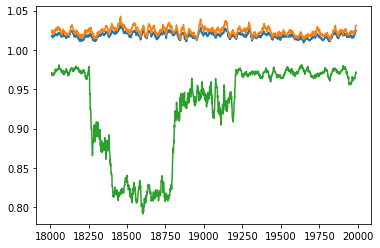

In [8]:
def moving_average(data_set, periods):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='same')

rg = range(18000, 20000)

bv = np.array([bucket_stat[idx]['revoted']/ bucket_stat[idx]['voted'] + 1 for idx in rg])
plt.plot(np.array(list(rg))[10:-10], moving_average(bv, 20)[10:-10])
bv = np.array([bucket_stat[idx]['voices']/ bucket_stat[idx]['voted'] for idx in rg])
plt.plot(np.array(list(rg))[10:-10], moving_average(bv, 20)[10:-10])
bv = np.array([bucket_stat[idx]['voted']/ bucket_stat[idx]['voters'] for idx in rg])
plt.plot(np.array(list(rg))[10:-10], moving_average(bv, 20)[10:-10])


In [9]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')
moving_average(bv)

array([0.98      , 0.96666667, 0.97      , ..., 0.97      , 0.96333333,
       0.95333333])

In [10]:
dstat = {}
for voter_id, _vdata in voter_data.items():
    district_id = _vdata['ballots'][0]['district_id'] if 'ballots' in _vdata else None
    if len(_vdata.get('ballots', [])) > 1:
        dstat[district_id] = dstat.get(district_id, 0) + 1
dstat

{204: 2477,
 206: 2206,
 198: 2399,
 202: 2778,
 199: 2485,
 197: 2082,
 210: 2182,
 207: 2468,
 203: 2331,
 200: 2280,
 201: 2168,
 208: 1883,
 196: 2240,
 205: 2110,
 209: 2205}

In [11]:
next(((k, v) for k, v in voter_data.items() if len(v.get('ballots', [])) > 1))

('11475633728483695492589133027047533545168636953454573849127262530664191932787',
 {'bucket': 0,
  'ballots': [{'datetime': datetime.datetime(2021, 9, 17, 21, 11, 58, 185000, tzinfo=datetime.timezone.utc),
    'district_id': 204},
   {'datetime': datetime.datetime(2021, 9, 17, 21, 11, 58, 185000, tzinfo=datetime.timezone.utc),
    'district_id': 204}]})